In [ ]:
## Vae for dna barcode sequence 50 dim and logistic regression

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import io
from google.colab import files
from numpy import argmax
from numpy import array
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

original_dim = 3290
intermediate_dim = 256
latent_dim = 50

In [ ]:
uploaded = files.upload()

Saving test_features.csv to test_features.csv
Saving train_features.csv to train_features.csv
Saving train_labels.csv to train_labels.csv


In [ ]:
train_features_df = pd.read_csv('train_features.csv')
train_labels_df = pd.read_csv('train_labels.csv')
test_features_df = pd.read_csv('test_features.csv')

In [ ]:
#get dna barcode sequencing data
def clean_seq(seq_df):
    sequences = seq_df['dna'].str.replace('[^ACGT]','N') #Converting all characters other than A, C, G, T as N
    for i in range(len(sequences)):
        sequences[i] = sequences[i].ljust(1058,'N')
    #print(sequences[0])
    
    sequences_array = np.array(sequences)
    #print(pd.DataFrame(sequences_array))
    seq_list_padded = []
    for i in range(len(sequences_array)):
        list_seq = list(sequences_array[i])
        del list_seq[658:] #truncating seq after 658 chacters
        seq_list_padded.append(list_seq)
    print(len(list_seq))
    replace_map = {'A': 1, 'C': 2, 'G': 3, 'T': 4, 'N': 5} 
    integer_encoded = []
    for i in range(len(seq_list_padded)):
        C = (pd.Series(seq_list_padded[i])).map(replace_map) #convert the list to a pandas series temporarily before mapping
        integer_encoded.append(list(C))
    data = np.array([1, 2, 3, 4, 5])
    data = data.reshape(-1, 1) 
    integer_encoded = np.array(integer_encoded).astype(int)
    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(data)
    one_hot_encoded_seqs = []
    for i in range(len(integer_encoded)):
        integer_encoded_tmp = integer_encoded[i].reshape(len(integer_encoded[i]), 1)
        onehot_encoded = np.array(onehot_encoder.transform(integer_encoded_tmp)).flatten()
        one_hot_encoded_seqs.append(onehot_encoded)
    one_hot_encoded_seqs_array = np.array(one_hot_encoded_seqs)
    #one_hot_encoded_seqs_array = one_hot_encoded_seqs_array.reshape(len(one_hot_encoded_seqs_array), 60, 60)
    #one_hot_encoded_seqs_array = np.expand_dims(one_hot_encoded_seqs_array, axis=3)
    
    return one_hot_encoded_seqs_array

def load_n_encode_labels(df):
    labels = df['labels']
    softmax_layer = len(set(labels))
    le = LabelEncoder()
    le.fit(labels)
    label_seq = le.transform(labels)
    label_seq = label_seq.reshape(len(label_seq), 1)
    
    return label_seq, le, softmax_layer

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

In [ ]:
one_hot_encoded_seqs_array_train = clean_seq(train_features_df)
one_hot_encoded_seqs_array_test = clean_seq(test_features_df)
one_hot_encoded_seqs_array = np.row_stack((one_hot_encoded_seqs_array_train, one_hot_encoded_seqs_array_test)) #combing train and test features
label_seq, le, softmax_layer = load_n_encode_labels(train_labels_df) #label_seq is encoded labels
x_train = one_hot_encoded_seqs_array
x_validation = one_hot_encoded_seqs_array_test
train_size = len(x_train)
batch_size = 32


658
658


In [ ]:
print(one_hot_encoded_seqs_array_train.shape)
print(one_hot_encoded_seqs_array_test.shape)
print(x_train.shape)
print(x_validation.shape)
x_train = x_train.astype(np.float32)

(12906, 3290)
(8306, 3290)
(21212, 3290)
(8306, 3290)


In [ ]:
# make sampling layer
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# Define encoder model.
original_inputs = tf.keras.Input(shape=(original_dim,), name="encoder_input")
x = layers.Dense(intermediate_dim, activation="relu")(original_inputs)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs=original_inputs, outputs=z, name="encoder")

# Define decoder model.
latent_inputs = tf.keras.Input(shape=(latent_dim,), name="z_sampling")
x = layers.Dense(intermediate_dim, activation="relu")(latent_inputs)
outputs = layers.Dense(original_dim, activation="sigmoid")(x)
decoder = tf.keras.Model(inputs=latent_inputs, outputs=outputs, name="decoder")

# Define VAE model.
outputs = decoder(z)
vae = tf.keras.Model(inputs=original_inputs, outputs=outputs, name="vae")

In [ ]:
# Add KL divergence regularization loss.
kl_loss = -0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
reconstruction_loss = binary_crossentropy(original_inputs,outputs)
reconstruction_loss *= original_dim
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

In [ ]:
epoch_num=200

# Create a callback that saves the model's weights
#https://jonathan-hui.medium.com/tensorflow-save-restore-model-75a1e6d3b9a6
#https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}", save_weights_only=True,
        save_best_only = True, monitor = "val_loss", verbose =1,)]

In [ ]:
# Train.
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)
vae.compile(optimizer, loss=tf.keras.losses.MeanSquaredError())
history = vae.fit(x_train, x_train, epochs=epoch_num, batch_size=128, callbacks=callbacks, validation_data=(x_validation, x_validation), verbose=1)

Epoch 1/200
166/166 [==============================] - 3s 12ms/step - loss: 596.6616 - val_loss: 413.8189

Epoch 00001: val_loss improved from inf to 413.81894, saving model to mymodel_1
Epoch 2/200
166/166 [==============================] - 2s 10ms/step - loss: 382.4518 - val_loss: 349.5706

Epoch 00002: val_loss improved from 413.81894 to 349.57056, saving model to mymodel_2
Epoch 3/200
166/166 [==============================] - 2s 10ms/step - loss: 332.9013 - val_loss: 311.2000

Epoch 00003: val_loss improved from 349.57056 to 311.20001, saving model to mymodel_3
Epoch 4/200
166/166 [==============================] - 2s 10ms/step - loss: 300.1068 - val_loss: 283.7178

Epoch 00004: val_loss improved from 311.20001 to 283.71777, saving model to mymodel_4
Epoch 5/200
166/166 [==============================] - 2s 10ms/step - loss: 275.3324 - val_loss: 260.5396

Epoch 00005: val_loss improved from 283.71777 to 260.53961, saving model to mymodel_5
Epoch 6/200
166/166 [====================

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

NameError: ignored

In [ ]:
def top10species_seqs_labels(train_features_df, train_labels_df):
    seq_array = np.array(train_features_df['dna'])
    seq_df = pd.DataFrame(seq_array)

    label_array = np.array(train_labels_df['labels'])
    label_df = pd.DataFrame(label_array)

    count_sorted = Counter(label_array).most_common(10)
    top_species_labels = [i[0] for i in count_sorted]

    seqs_per_top_species = [[] for x in range(10)]
    for i in range(len(top_species_labels)):
        Index_of_labels = np.where(label_df == top_species_labels[i])
        seqs_by_species = seq_df.iloc[Index_of_labels[0],:]
        seqs_per_top_species[i].append(np.array(seqs_by_species))

    seqs_per_top_species_list = []
    for i in range(10):
        seqs_per_top_species_list.append(seqs_per_top_species[i][0].tolist())

    top_species_seq_list = []
    for i in range(len(seqs_per_top_species_list)):
        for j in range(len(seqs_per_top_species_list[i])):
            top_species_seq_list.append(seqs_per_top_species_list[i][j])
    top_species_features_df = pd.DataFrame(top_species_seq_list, columns = ['dna'])

    labels_per_top_species = [[] for x in range(10)]
    for i in range(len(top_species_labels)):
        Index_of_labels = np.where(label_df == top_species_labels[i])
        labels_by_species = label_df.iloc[Index_of_labels[0],:]
        labels_per_top_species[i].append(np.array(labels_by_species))

    labels_per_top_species_list = []
    for i in range(10):
        labels_per_top_species_list.append(labels_per_top_species[i][0].tolist())

    top_species_label_list = []
    for i in range(len(labels_per_top_species_list)):
        for j in range(len(labels_per_top_species_list[i])):
            top_species_label_list.append(labels_per_top_species_list[i][j])
    top_species_labels_df = pd.DataFrame(top_species_label_list, columns = ['labels'])

    return top_species_features_df, top_species_labels_df

In [ ]:
top_species_features_df, top_species_labels_df = top10species_seqs_labels(train_features_df, train_labels_df)
print(top_species_features_df)
print(top_species_labels_df)
one_hot_encoded_seqs_array_top10_species = clean_seq(top_species_features_df)

                                                   dna
0    ---------------------------------------------A...
1    ----------------------------------------------...
2    --------------------------GATCGGGAATTTTAGGGATA...
3    ------------------------------------TTTAGGGATA...
4    ---------------------------------------------A...
..                                                 ...
783  AACATTATATTTTATTTTCGGAGCTTGAGCCGGTATAGTAGGAACA...
784  AACATTATATTTTATTTTCGGAGCTTGAGCCGGTATAGTAGGAACA...
785  AACATTATATTTTATTTTCGGAGCTTGAGCCGGTATAGTAGGGACA...
786  CTTGAGCCGGTATAGTAGGGACATCTCTGAGAATTTTAATTCGAGC...
787  AACATTATATTTTATTTTCGGAGCTTGAGCCGGTATAGTAGGAACA...

[788 rows x 1 columns]
     labels
0      1162
1      1162
2      1162
3      1162
4      1162
..      ...
783    1212
784    1212
785    1212
786    1212
787    1212

[788 rows x 1 columns]
658


In [ ]:
from sklearn.manifold import TSNE

x_train_encoded = encoder.predict(one_hot_encoded_seqs_array_top10_species)
top_species_labels_array = np.array(top_species_labels_df).astype(int)
labels_train = top_species_labels_array.T
tsne_model = TSNE(n_components=2, random_state=0)
tsne_data = tsne_model.fit_transform(x_train_encoded)
# creating a new data frame which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, labels_train)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


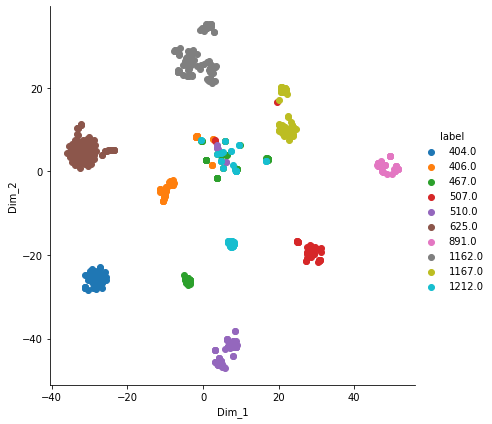

In [ ]:
import seaborn as sn
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

(788, 1)


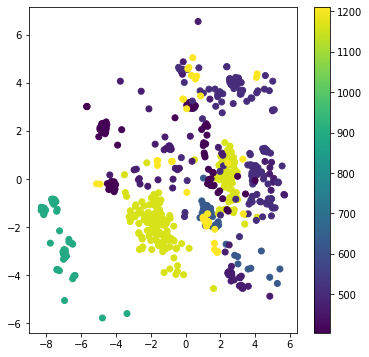

In [ ]:
top_species_labels_array = np.array(top_species_labels_df).astype(int)
print(top_species_labels_array.shape)

x_train_encoded = encoder.predict(one_hot_encoded_seqs_array_top10_species)
plt.figure(figsize=(6, 6))
plt.scatter(x_train_encoded[:, 0], x_train_encoded[:, 1], c=top_species_labels_array)
plt.colorbar()
plt.show()

In [ ]:
## Classification using logistic regression

In [ ]:
x_train_encoded = encoder.predict(one_hot_encoded_seqs_array_train)
print(x_train_encoded)
print(x_train_encoded.shape)

[[ 0.52372646 -3.157851   -1.6690024  ... -1.3234823   0.80905443
  -1.1884407 ]
 [ 2.2878747   1.3625405  -5.825822   ... -0.17087388 -0.9272427
  -0.6385677 ]
 [-3.2623363   1.1230118   1.7122422  ...  3.6066308  -0.22395393
  -1.8940198 ]
 ...
 [ 3.8216023  -0.78310513 -2.6146374  ... -2.4080982   0.13784531
   0.1115496 ]
 [ 4.189299    0.092253   -3.0584128  ...  2.799148   -3.3324482
  -4.276249  ]
 [ 0.44605643  3.0066242   2.5661893  ... -0.72795624  0.13210955
   0.42691392]]
(12906, 50)


In [ ]:
label_seq = np.ravel(label_seq)
x_sample_train, x_test, y_sample_train, y_test = train_test_split(x_train_encoded, label_seq, test_size=0.25)

In [ ]:
print(len(label_seq))

12906


In [ ]:
from sklearn.linear_model import LogisticRegression

logisticRegr = LogisticRegression(random_state=0)
logisticRegr.fit(x_sample_train, y_sample_train)
predictions = logisticRegr.predict(x_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [ ]:
score = logisticRegr.score(x_test, y_test)
print("Accuracy:", score)

Accuracy: 0.9491788038425782


In [ ]:
## Test prediction

In [ ]:
x_test_encoded = encoder.predict(one_hot_encoded_seqs_array_test)

encoded_predictions = logisticRegr.predict(x_test_encoded)
print(encoded_predictions)

def decode_labels(encoded_predict_labels, le):
    test_predictions = le.inverse_transform(encoded_predict_labels)
    
    return test_predictions

test_seq_predictions = decode_labels(encoded_predictions, le)
print(test_seq_predictions)

[ 659    7  200 ...  919 1059  590]
[ 667    8  205 ...  929 1071  597]


In [ ]:
def get_seq_ids(filename):
    df = pd.read_csv(filename)
    ids = df['id']
    
    return np.array(ids)

test_ids = get_seq_ids(filename_features_test)
print(test_ids)

frames = [pd.DataFrame(test_ids), pd.DataFrame(test_seq_predictions)]
output_data= np.concatenate(frames, axis=1)
output_df = pd.DataFrame(output_data)
output_df.to_csv('dna_barcode_seq_submission7_vae_embedding_LR.csv', index=False,  header=["id","labels"])

[   1    2    3 ... 8304 8305 8306]


In [ ]:
from google.colab import files
files.download("dna_barcode_seq_submission7_vae_embedding_LR.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>